In [44]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import json
from pprint import pprint

from scipy import stats

import gzip

# pip install ipywidgets --user
# jupyter nbextension install --py  widgetsnbextension --user
# jupyter nbextension enable widgetsnbextension --user --py
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt

In [45]:
! curl "https://data.ny.gov/api/views/d6yy-54nr/rows.json?accessType=DOWNLOAD" | gzip -1 -c > data.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  165k    0  165k    0     0   125k      0 --:--:--  0:00:01 --:--:--  125k


In [46]:
js = json.load(gzip.open("data.json.gz"))
columns = [x for x in js["meta"]["view"]["columns"]]
colnames = [c[("dataTypeName" if c["id"]>=0 else "name")] for c in columns]

dfc = pd.DataFrame(js["data"],columns=colnames)
dfc = dfc.drop(["sid","id","position","created_at","created_meta","updated_at","updated_meta","meta"],axis=1)
dfc = dfc.rename(columns={"number":"multiplier","text":"numbers","calendar_date":"date"})
dfc.head()

,date,numbers,multiplier
0,2019-05-29T00:00:00,03 32 34 42 61 07,2
1,2019-05-25T00:00:00,01 02 39 43 66 02,3
2,2019-05-22T00:00:00,07 10 20 44 57 03,2
3,2019-05-18T00:00:00,02 10 25 66 67 26,4
4,2019-05-15T00:00:00,07 17 33 61 68 04,2


In [47]:
dfc.date = pd.to_datetime(dfc.date)
dfc.multiplier = pd.to_numeric(dfc.multiplier)
dfc.numbers = dfc.numbers.str.split()

In [48]:
numbers = map(int,dfc.numbers.values.sum())
numbers = pd.Series(numbers)
numbers.head()

0     3
1    32
2    34
3    42
4    61
dtype: int64

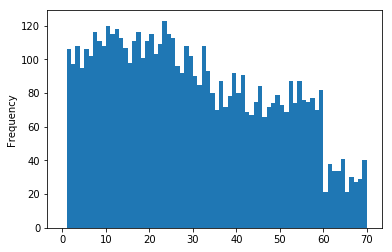

In [49]:
numbers.plot.hist(bins=np.linspace(0,70,71))

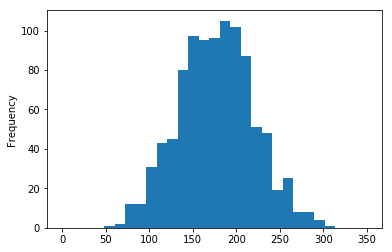

In [50]:
sums = dfc.numbers.map(lambda x:sum(map(int,x)))
sums.plot.hist(bins=np.linspace(0,350,30))

In [51]:
def f(x):
    nums = np.array(map(float,x.numbers.sum()))
    return pd.DataFrame(np.c_[
        nums.mean(), nums.std(), nums.size,x.multiplier.mean(),x.multiplier.sum(),x.multiplier.shape,
    ],columns=["num_mean","num_std","num_size","mult_mean","mult_sum","mult_size"])
dfg = dfc.set_index("date").resample("M").apply(f).reset_index()
dfg.head()

,date,level_1,num_mean,num_std,num_size,mult_mean,mult_sum,mult_size
0,2010-02-28,0,29.937500,17.066544,48.0,2.875000,23.0,8.0
1,2010-03-31,0,27.240741,16.384201,54.0,3.222222,29.0,9.0
2,2010-04-30,0,30.833333,17.561005,48.0,3.000000,24.0,8.0
3,2010-05-31,0,29.518519,17.267761,54.0,3.333333,30.0,9.0
4,2010-06-30,0,29.129630,15.396063,54.0,4.666667,42.0,9.0


Text(0,0.5,'mean ball number')

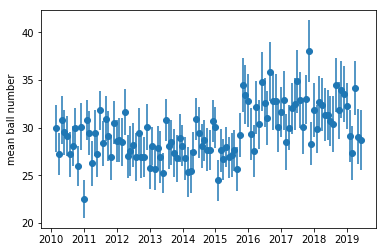

In [52]:
fig,ax = plt.subplots()
# ax.plot_date(dates,dfg["mean"])
# ax.errorbar(dates, dfg["mult_mean"])
ax.errorbar(dfg.date, dfg["num_mean"], yerr=dfg["num_std"]/dfg["num_size"]**0.5, fmt="o")
ax.set_ylabel("mean ball number")

In [53]:
df = dfg[dfg.date < pd.to_datetime("2015-06-01")].copy()
df["dateord"] = df.date.apply(lambda x:x.toordinal())
m, b, r, pval, err = stats.linregress(df["dateord"],df["num_mean"])
df["fit"] = df["dateord"]*m+b
df.head()

,date,level_1,num_mean,num_std,num_size,mult_mean,mult_sum,mult_size,dateord,fit
0,2010-02-28,0,29.937500,17.066544,48.0,2.875000,23.0,8.0,733831,28.798902
1,2010-03-31,0,27.240741,16.384201,54.0,3.222222,29.0,9.0,733862,28.777903
2,2010-04-30,0,30.833333,17.561005,48.0,3.000000,24.0,8.0,733892,28.757581
3,2010-05-31,0,29.518519,17.267761,54.0,3.333333,30.0,9.0,733923,28.736582
4,2010-06-30,0,29.129630,15.396063,54.0,4.666667,42.0,9.0,733953,28.716261


Text(0,0.5,'mean ball number')

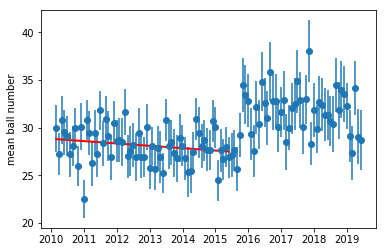

In [54]:
fig,ax = plt.subplots()
ax.errorbar(dfg.date, dfg["num_mean"], yerr=dfg["num_std"]/dfg["num_size"]**0.5, fmt="o")
ax.plot_date(df["date"],df["fit"],fmt="-",lw=2,color="r")
ax.set_ylabel("mean ball number")

In [55]:
def animation(days):
    fig,ax = plt.subplots()
    days = max(min(days,500),10)
    def f(x):
        nums = np.array(map(float,x.numbers.sum()))
        return pd.DataFrame(np.c_[
            nums.mean(), nums.std(), nums.size,x.multiplier.mean(),x.multiplier.sum(),x.multiplier.shape,
        ],columns=["num_mean","num_std","num_size","mult_mean","mult_sum","mult_size"])
    dfg = dfc.set_index("date").resample("{}d".format(days)).apply(f).reset_index()
    ax.errorbar(dfg.date, dfg["num_mean"], yerr=dfg["num_std"]/dfg["num_size"]**0.5, fmt="o",label="grouped by {} days".format(days))
    
    df = dfg[dfg.date < pd.to_datetime("2015-06-01")].copy()
    df["dateord"] = df.date.apply(lambda x:x.toordinal())
    m, b, r, pval, err = stats.linregress(df["dateord"],df["num_mean"])
    df["fit"] = df["dateord"]*m+b
    
    ax.plot_date(df["date"],df["fit"],fmt="-",lw=2,color="r")

    ax.set_ylabel("mean ball number")
    ax.legend()
    
interact(animation, days=75);

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT03NSwgZGVzY3JpcHRpb249dSdkYXlzJywgbWF4PTIyNSwgbWluPS03NSksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3figKY=
